In [12]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
current_path = os.getcwd().split("Model")[0]
from Model.EBMsAndMethod.DistributionEstimation.ais_importance_weighted_ebm import AISImportanceWeightedEBM
from Model.Energy.Distribution.ExplicitBiasForDistribution import MockBias
from Model.Proposals.ProposalForDistributionEstimation.gaussian import Gaussian
from hydra_config import store_main
from hydra import compose, initialize_config_dir
from argparse import ArgumentParser

from Model.Proposals.mock_base_dist import MockBaseDist

import hydra


In [13]:
def clear_hydra():
    hydra.core.global_hydra.GlobalHydra.instance().clear()

def get_config(config_path = "conf_test", config_name = "config"):
    # Test for all prior distributions
    clear_hydra()
    store_main()
    print(current_path)
    initialize_config_dir(config_dir=os.path.join(current_path, config_path), job_name="test_app")
    # initialize(config_path=config_path, job_name="test_app")
    cfg = compose(config_name=config_name, overrides=[])
    return cfg

In [14]:
import torch.nn as nn
class stupid_f_theta(nn.Module):
    def __init__(self):
        super(stupid_f_theta, self).__init__()   
        mean = torch.zeros(1,2) 
        cov = torch.ones(1,2) * 0.3
        dist_gaussian = torch.distributions.Normal(mean, cov)                    
        self.f_theta = lambda x: -dist_gaussian.log_prob(x)
    
    def forward(self, x):
        energy = self.f_theta(x).flatten(1).sum(-1,keepdim=True)
        return energy
        
class StupidProposal(nn.Module):
    def __init__(self):
        super(StupidProposal, self).__init__()
        self.mean = torch.zeros(1,2)
        self.cov = torch.ones(1,2)
        self.dist_gaussian = torch.distributions.Normal(self.mean, self.cov)
        self.dim = 2

    def sample(self, nb_sample, return_log_prob = False):
        if not return_log_prob :
            return self.dist_gaussian.sample((nb_sample,))
        else :
            samples = self.dist_gaussian.sample((nb_sample,))
            log_probs = self.dist_gaussian.log_prob(samples).flatten(1).sum(-1,keepdim=True)
            return samples, log_probs
        
    def log_prob(self, x):
        return self.dist_gaussian.log_prob(x).flatten(1).sum(-1,keepdim=True)

In [15]:

proposal_distribution = StupidProposal()
explicit_bias = MockBias()
base_dist= MockBaseDist()
f_theta = stupid_f_theta()
cfg = get_config()
cfg.ebm.nb_transitions_ais = 100
nb_sample = 100



/Users/hhjs/Documents/Projects/SelfNormalizedLikelihood/


/var/folders/j8/dm7qjtj55w3f6yvlj6rd2vx40000gn/T/ipykernel_25382/3062668526.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize_config_dir(config_dir=os.path.join(current_path, config_path), job_name="test_app")


In [16]:
ebm = AISImportanceWeightedEBM(f_theta, proposal_distribution, base_dist, explicit_bias=explicit_bias, cfg_ebm=cfg.ebm)

Sampling_AIS
0.0
tensor(-0.0352, grad_fn=<SubBackward0>)


In [17]:

samples, log_prob = ebm.sample_ais(nb_sample, return_full_list=True, return_log_prob=True)
print(ebm.explicit_bias)
print(samples[0].shape)
print(len(samples))
# print((ebm.calculate_energy(samples[0], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[0]).logsumexp(0) - np.log(nb_sample))
print((-f_theta(samples[0]).reshape(nb_sample,1) + base_dist.log_prob(samples[0]) - log_prob[0]).logsumexp(0) - np.log(nb_sample))
print((-f_theta(samples[1]).reshape(nb_sample,1) + base_dist.log_prob(samples[1]) - log_prob[1]).logsumexp(0) - np.log(nb_sample))
print((-f_theta(samples[2]).reshape(nb_sample,1) + base_dist.log_prob(samples[2]) - log_prob[2]).logsumexp(0) - np.log(nb_sample))
print((-ebm.calculate_energy(samples[-1], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[-1]).logsumexp(0) - np.log(nb_sample))
importance_weight = ebm.calculate_energy(samples[-1], use_base_dist=True)[0].reshape(nb_sample,1) - log_prob[-1].reshape(nb_sample,1)


Sampling_AIS
MockBias()
torch.Size([100, 1, 2])
101
tensor([0.2011], grad_fn=<SubBackward0>)
tensor([0.1254], grad_fn=<SubBackward0>)
tensor([0.0946], grad_fn=<SubBackward0>)
tensor([0.1194], grad_fn=<SubBackward0>)


In [18]:
ebm.estimate_log_z(torch.zeros_like(samples[-1]), nb_sample=1000, sample_function=ebm.sample_ais)

Sampling_AIS
0.0
tensor(-0.0323, grad_fn=<SubBackward0>)


[tensor(-0.0323, grad_fn=<SubBackward0>),
 {'z_estimation/f_theta_no_bias_on_sample_proposal': tensor([[ 2.4805e-01],
          [-3.4817e-01],
          [-4.1214e-01],
          [ 1.5815e-01],
          [-5.6113e-01],
          [ 9.2491e-01],
          [-2.8089e-01],
          [-5.3347e-01],
          [-5.0989e-01],
          [ 7.6449e-01],
          [-5.5411e-01],
          [-2.5080e-01],
          [ 2.8336e-01],
          [ 1.1241e+00],
          [ 2.7389e+00],
          [ 1.0057e+00],
          [-5.6763e-01],
          [ 6.2421e-01],
          [-2.1502e-01],
          [ 1.3219e+00],
          [ 1.1224e+00],
          [-1.9772e-01],
          [ 9.7965e-01],
          [ 1.0147e+00],
          [ 8.2966e-01],
          [ 1.4796e+00],
          [ 2.3319e-01],
          [-3.0760e-01],
          [ 1.5707e-01],
          [ 3.5130e-01],
          [-2.3006e-01],
          [-5.4995e-01],
          [ 7.9851e-01],
          [ 4.9007e-01],
          [ 1.1045e+00],
          [-3.8708e-01],
       

In [8]:
for k in range(1):
    aux_samples, log_prob = ebm.sample(nb_sample, return_log_prob=True)
    aux_importance = -f_theta(aux_samples).reshape(nb_sample,1) + base_dist.log_prob(aux_samples) - proposal_distribution.log_prob(aux_samples).reshape(nb_sample,1) 
    print(aux_importance.logsumexp(0) - np.log(nb_sample))


Sampling traditional
tensor([0.1311])


In [9]:
print(importance_weight.mean())
print(aux_importance.mean())


tensor(-0.8106, grad_fn=<MeanBackward0>)
tensor(-9.2347)


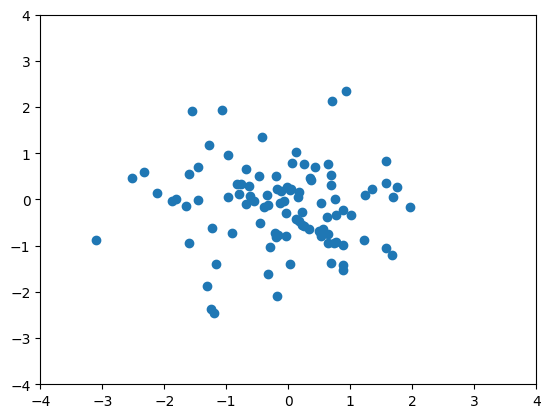

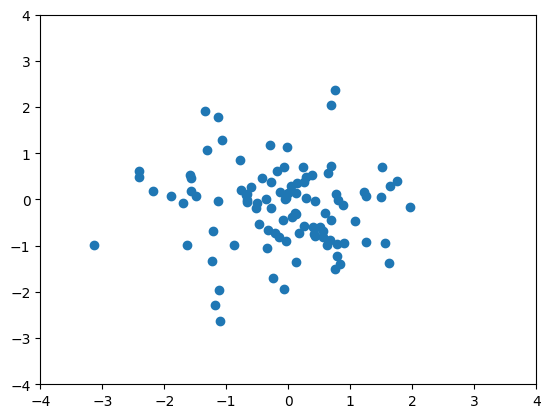

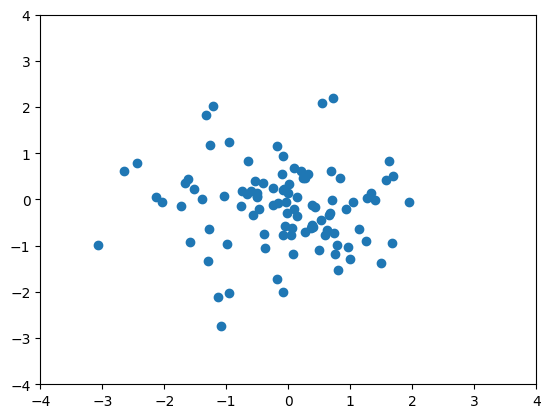

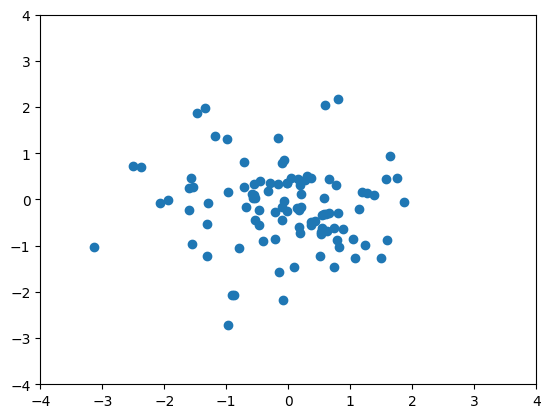

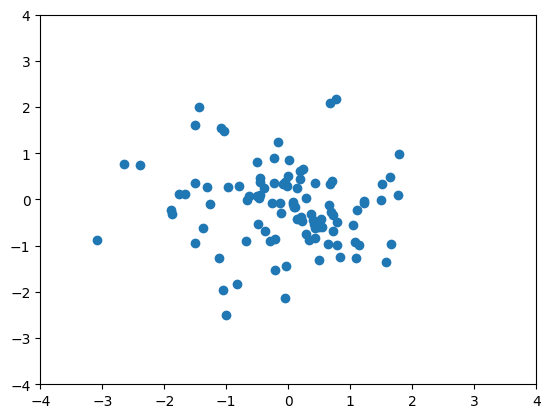

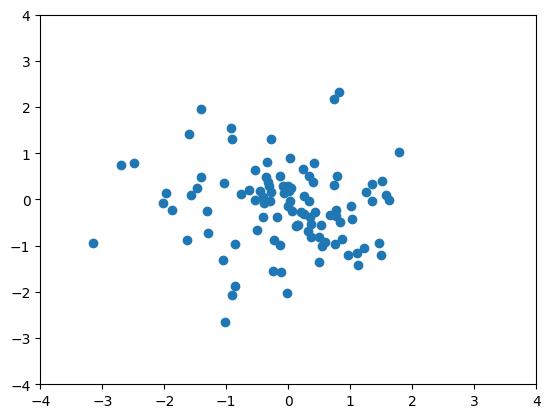

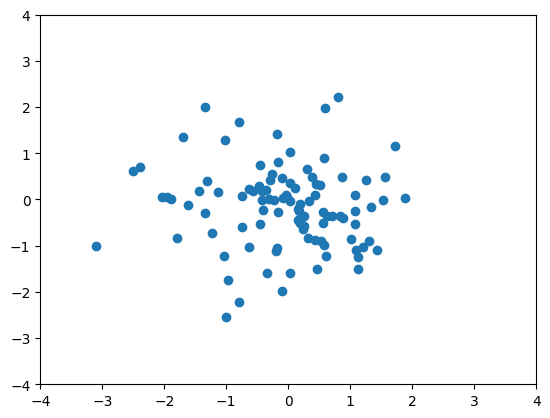

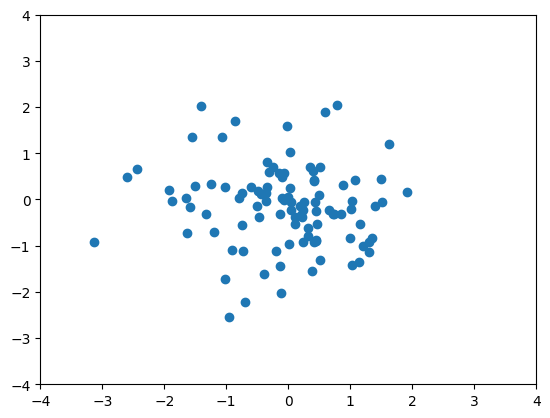

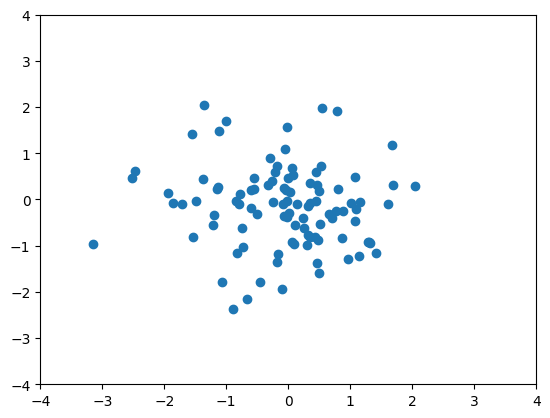

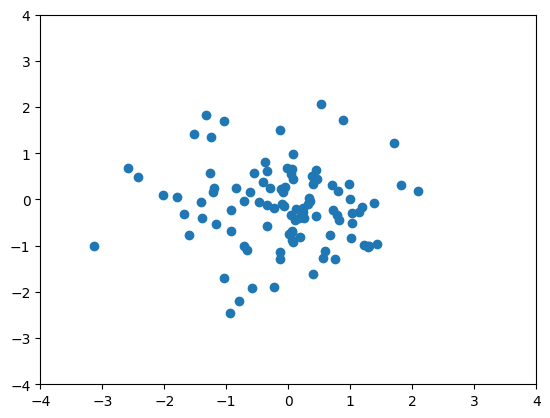

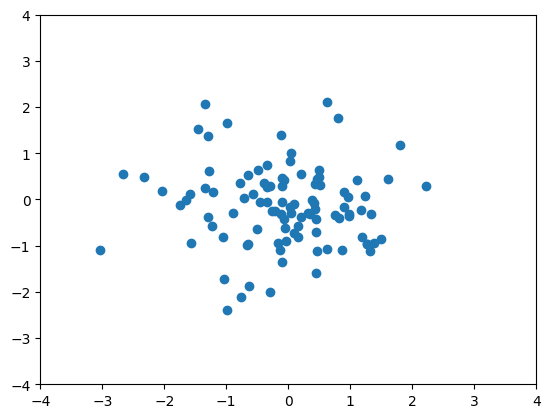

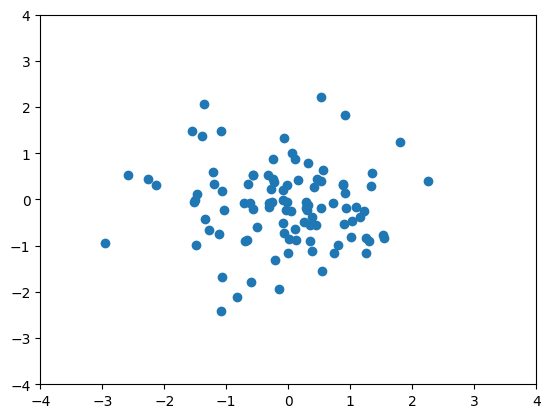

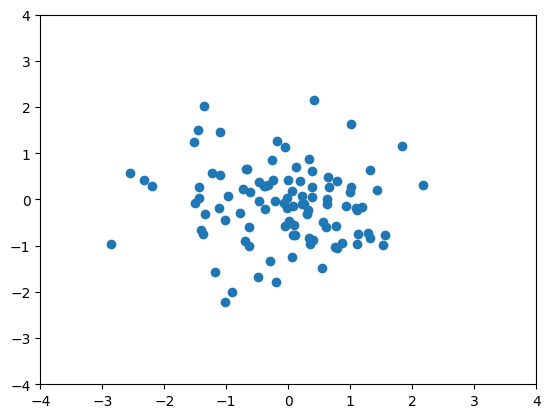

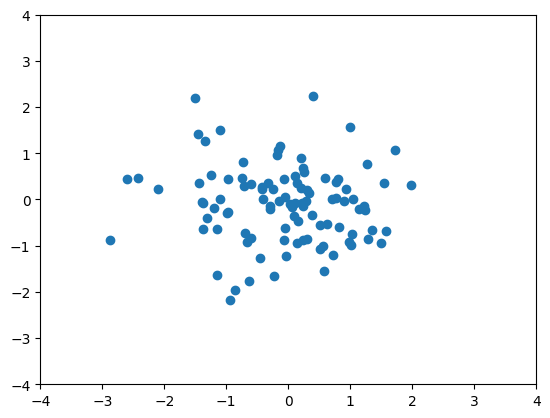

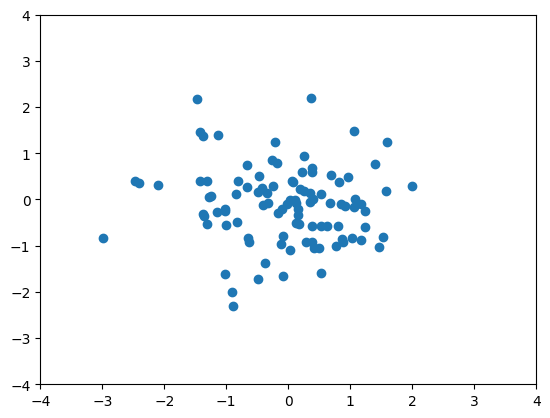

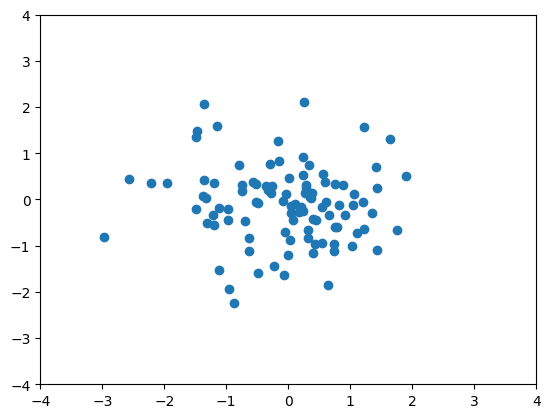

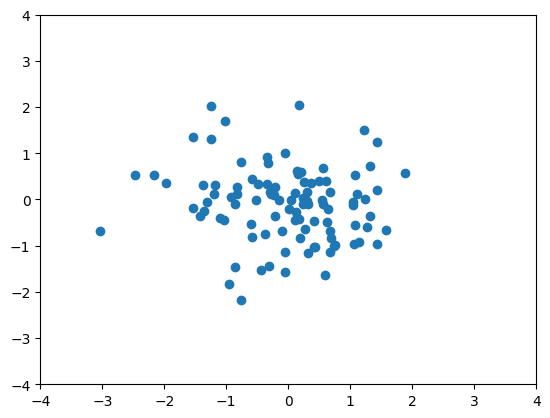

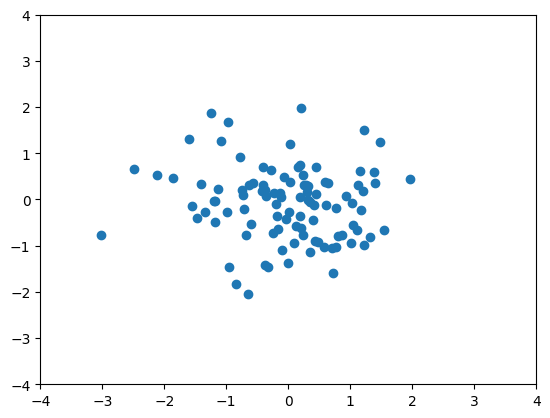

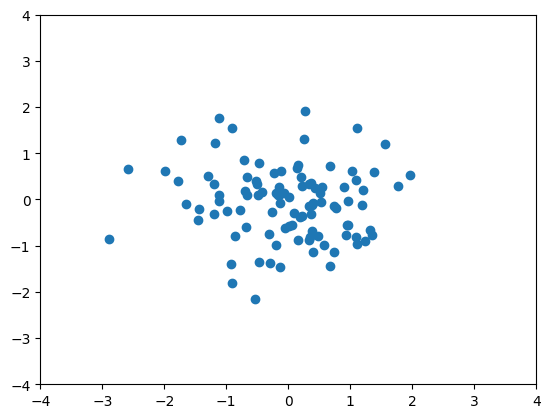

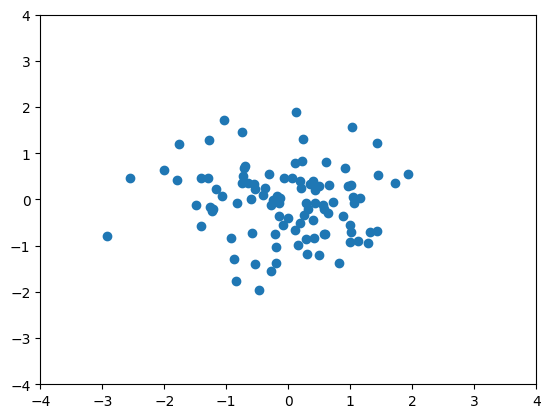

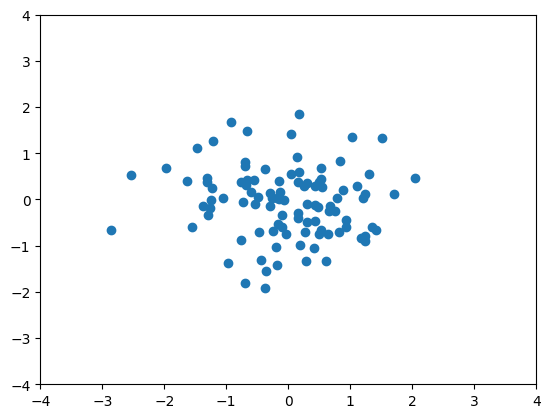

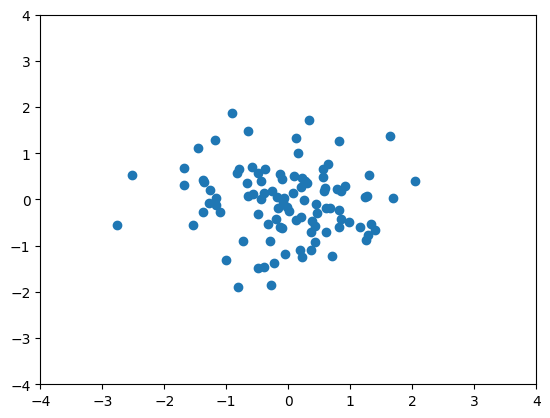

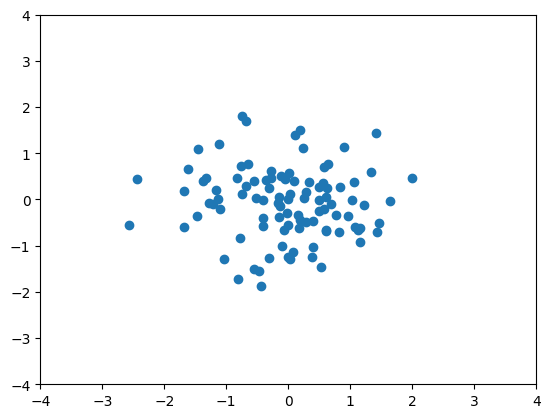

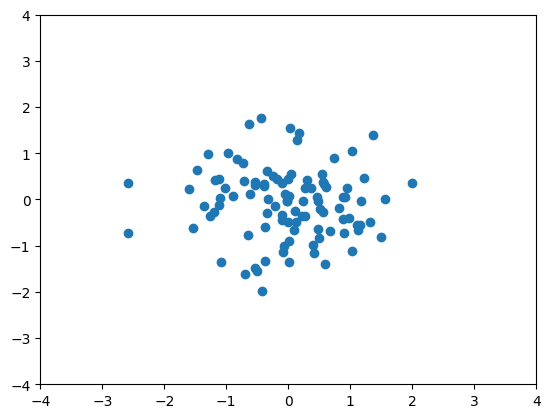

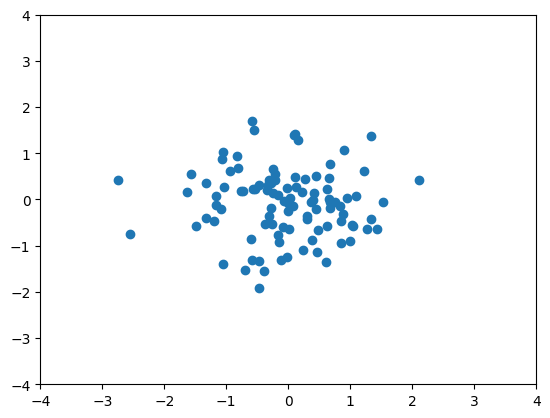

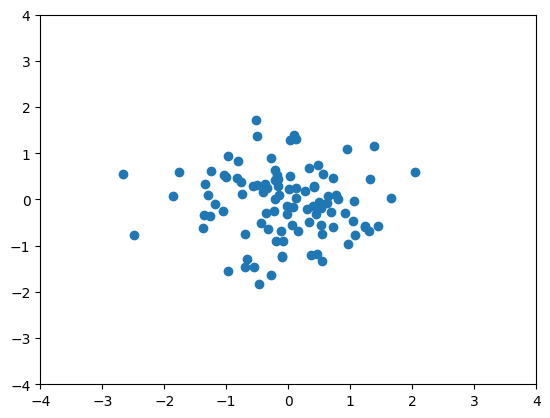

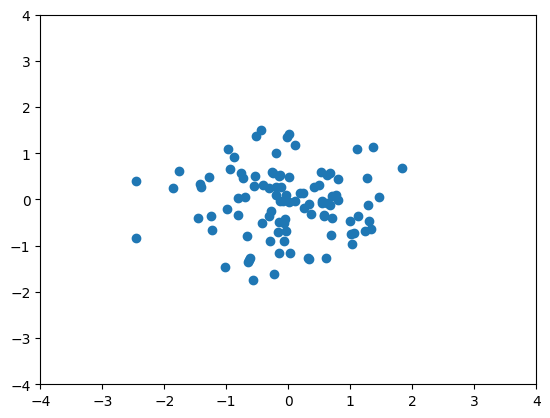

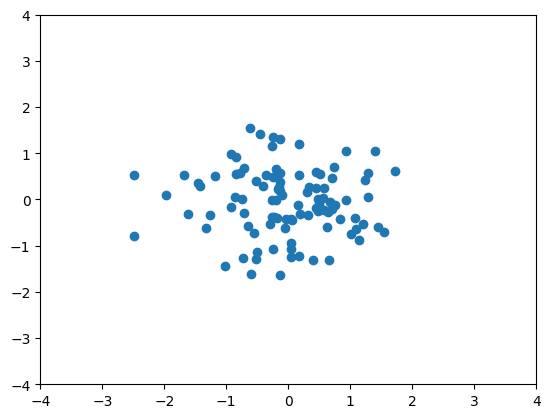

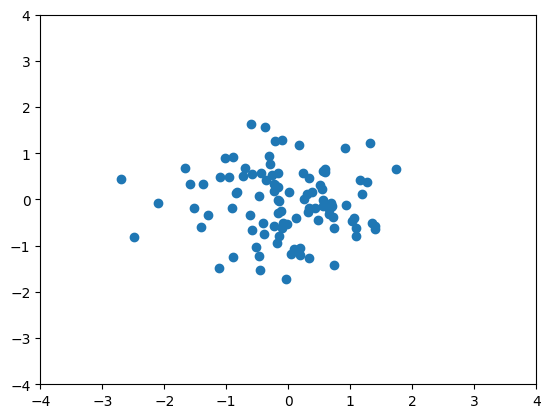

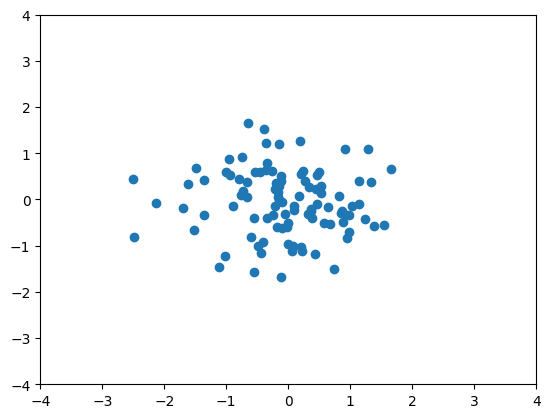

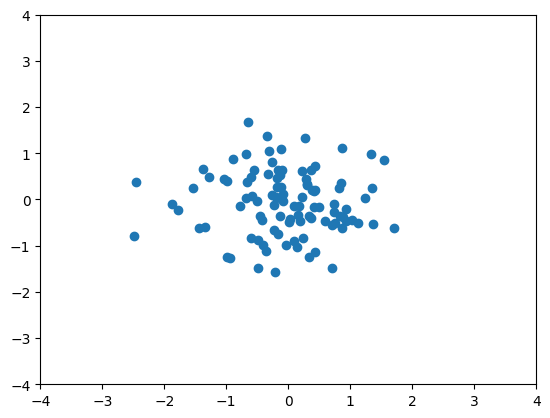

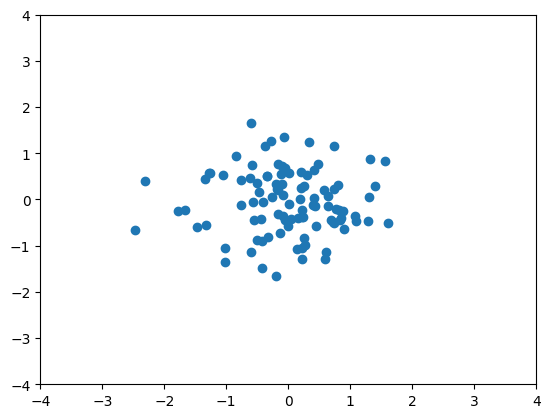

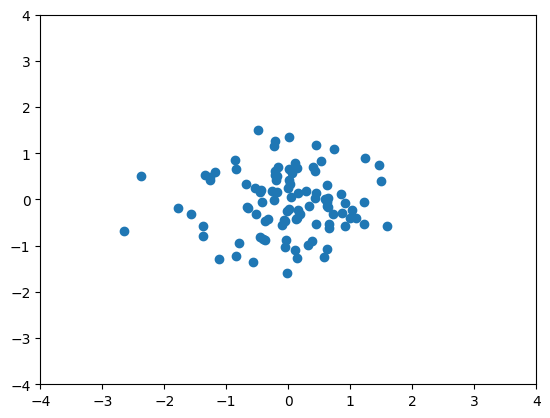

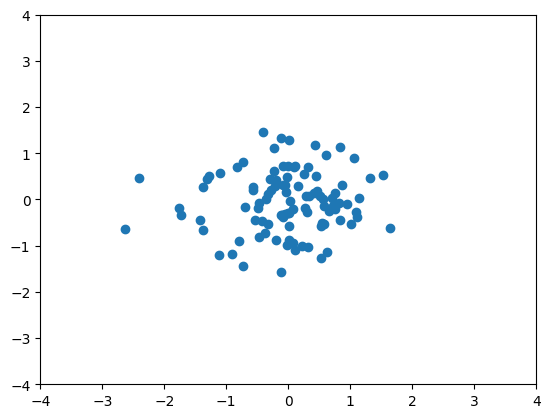

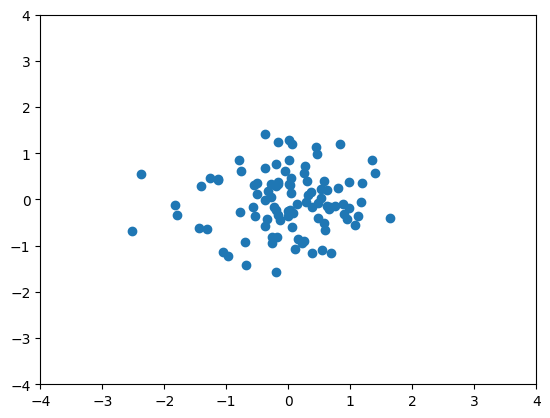

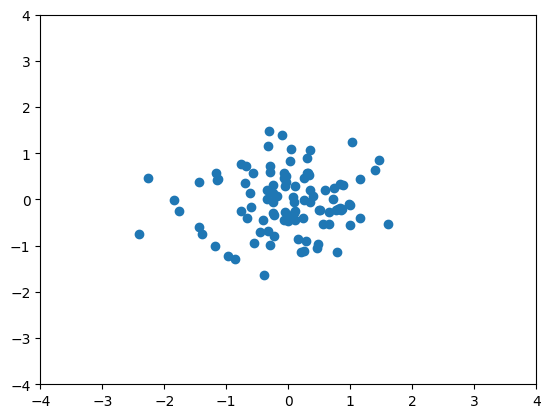

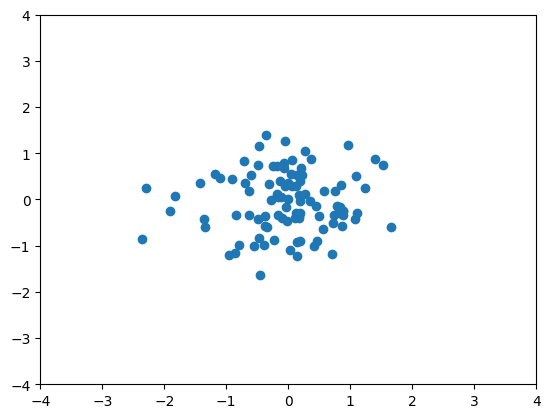

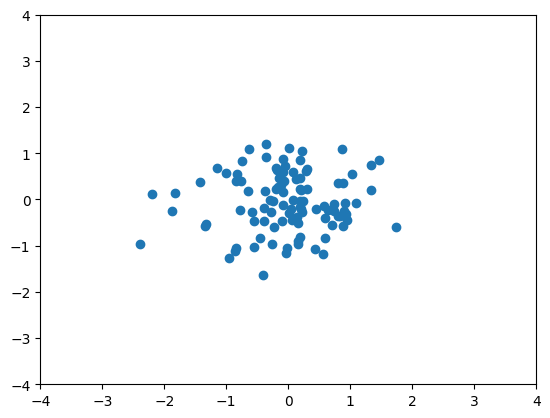

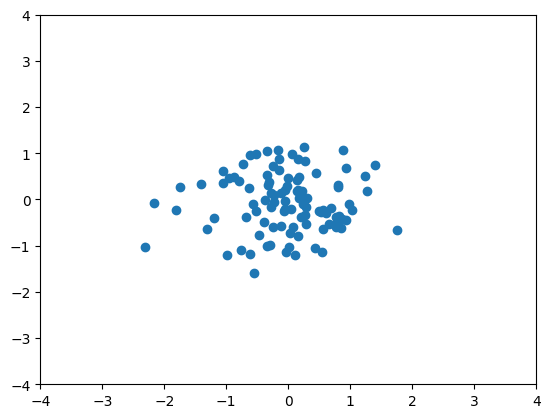

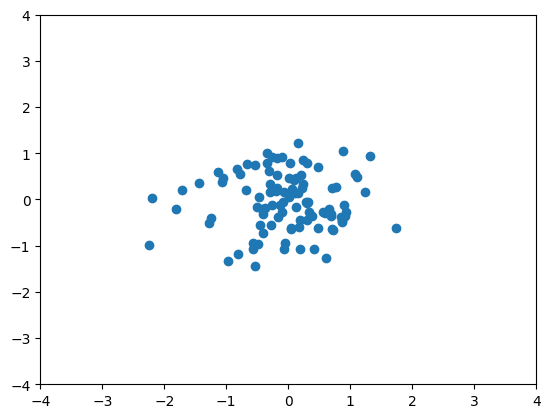

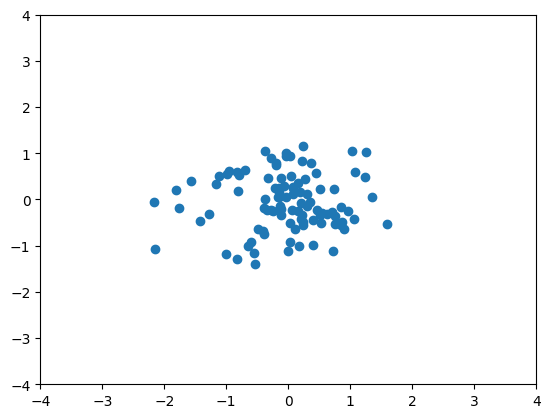

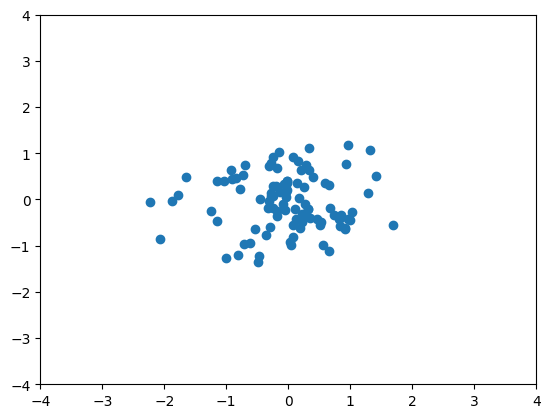

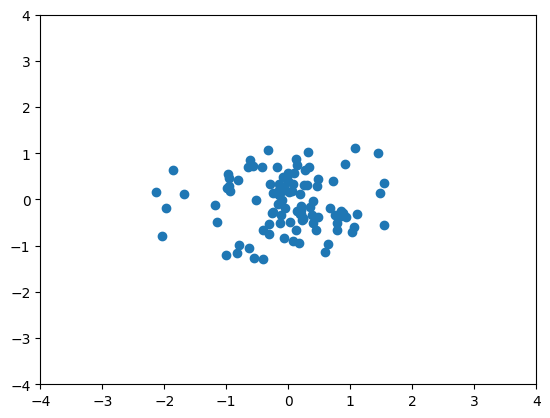

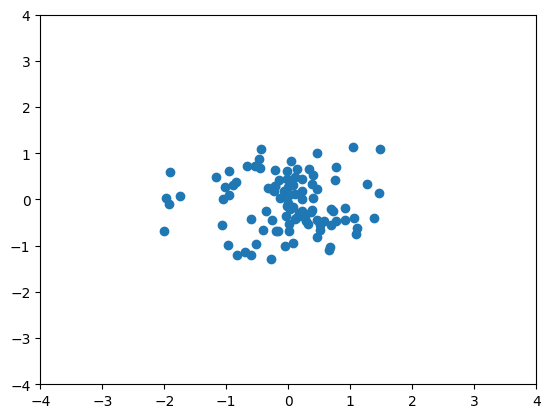

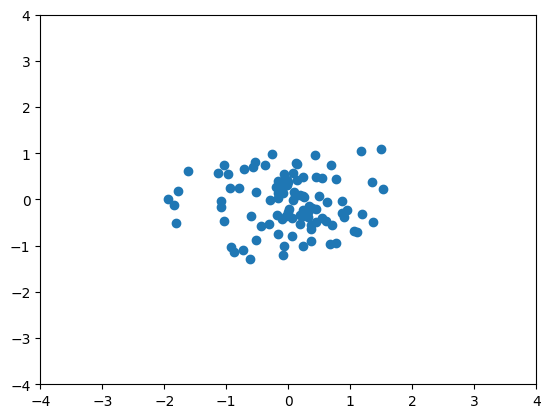

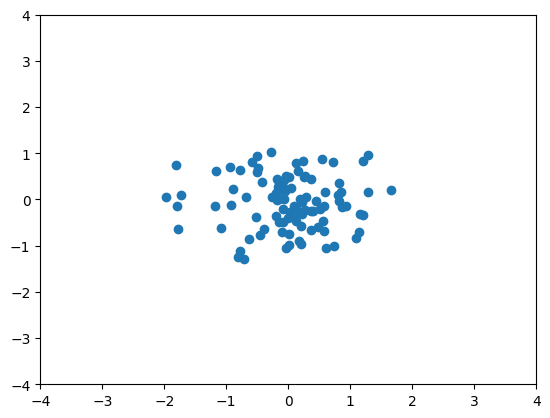

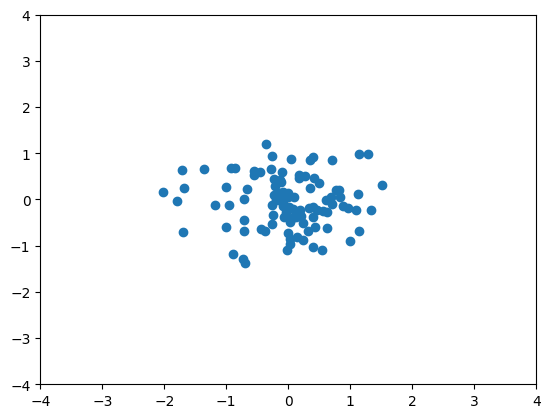

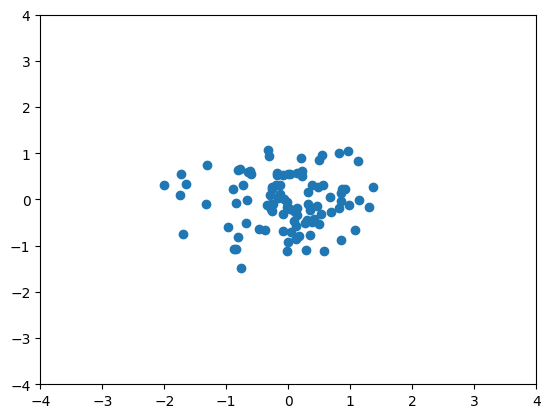

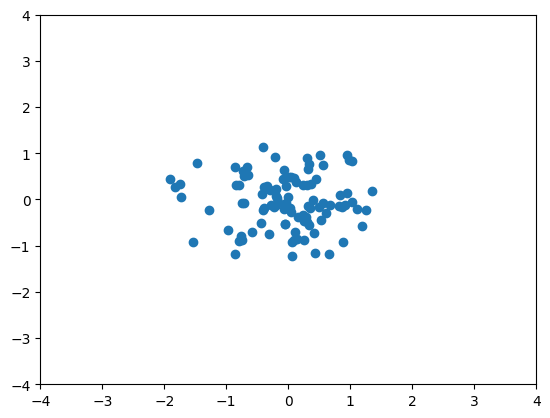

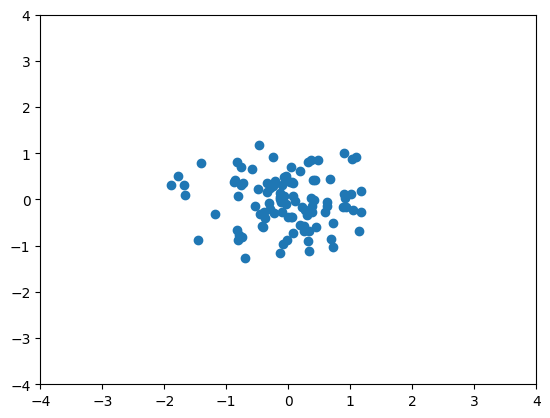

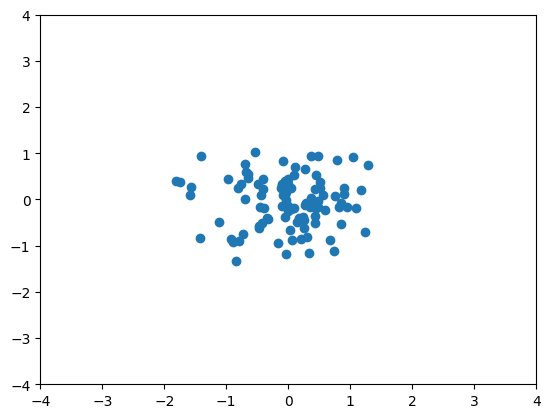

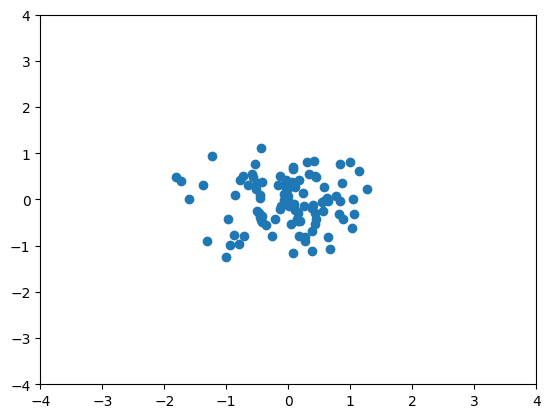

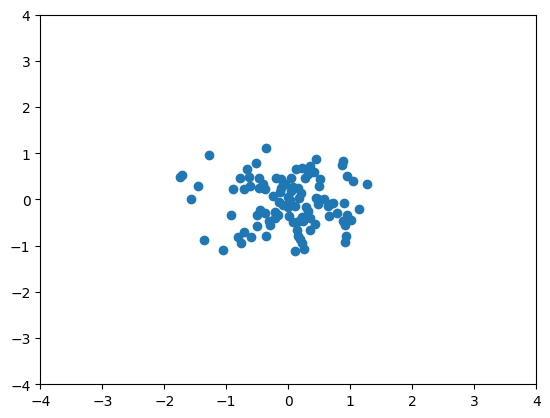

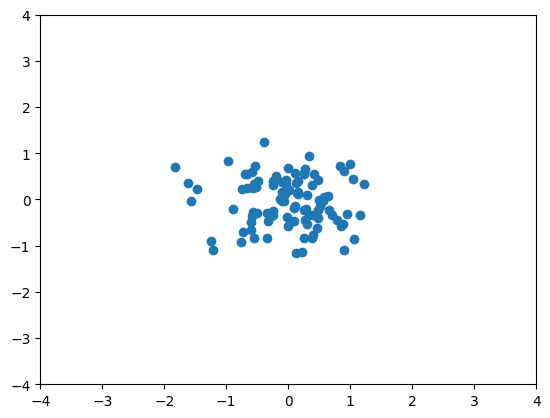

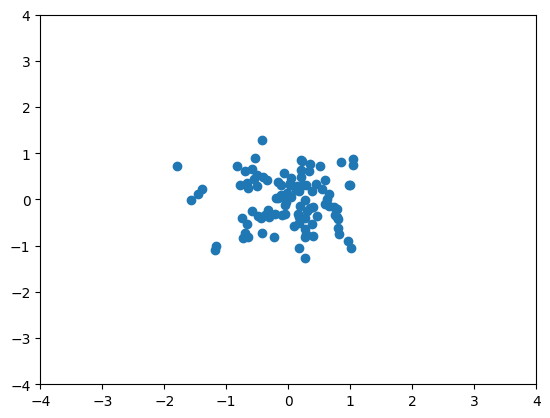

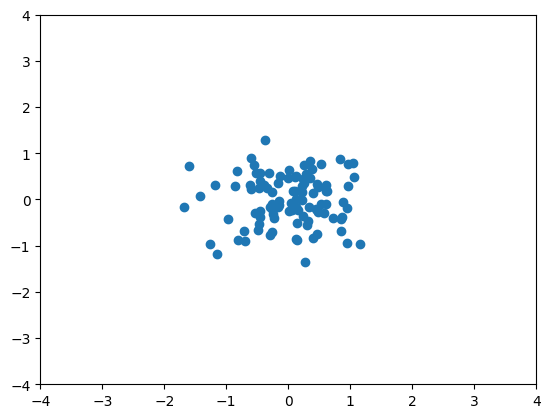

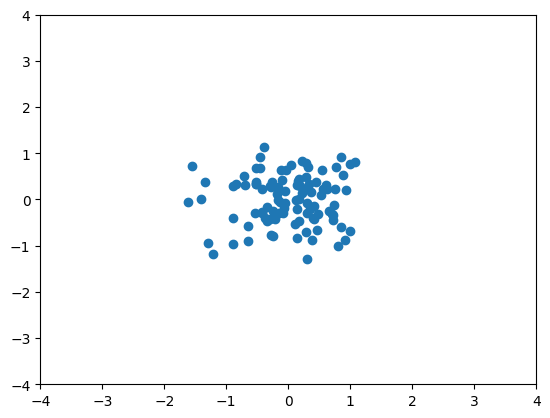

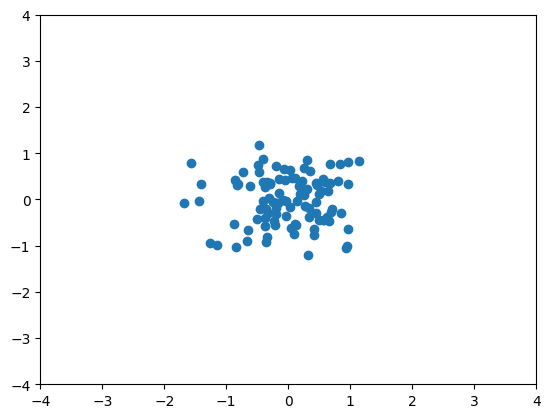

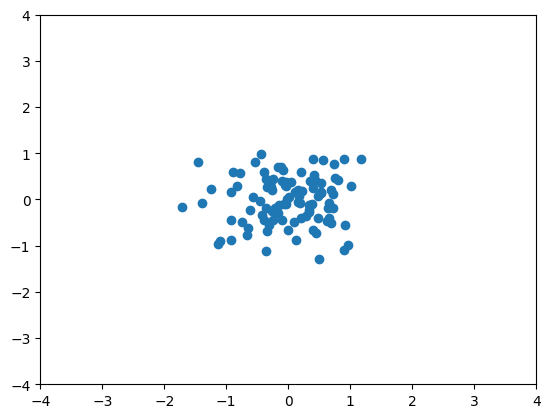

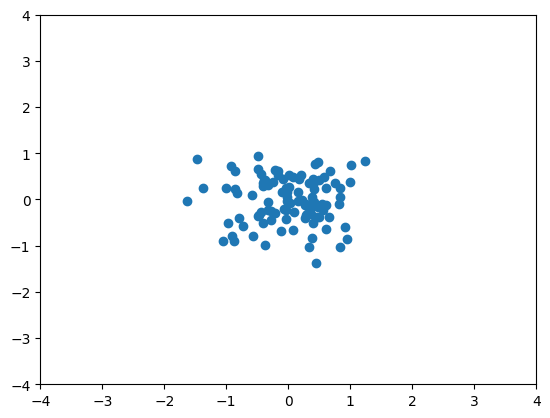

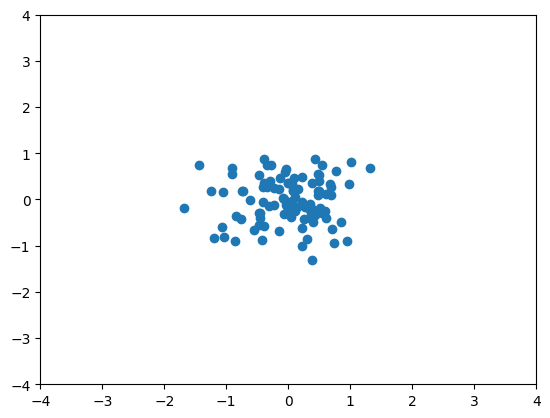

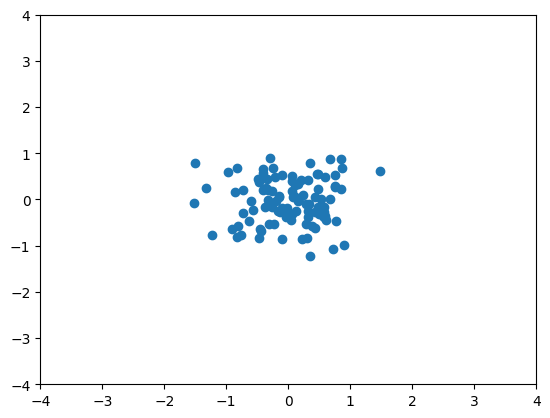

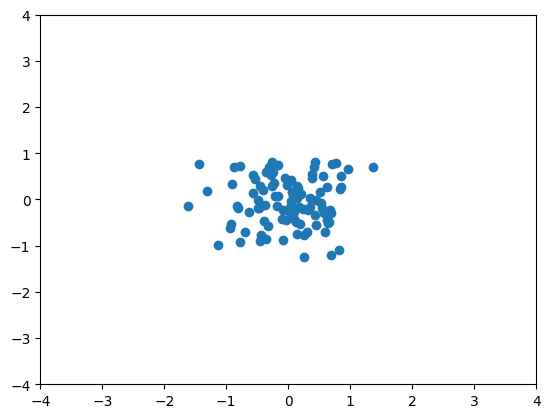

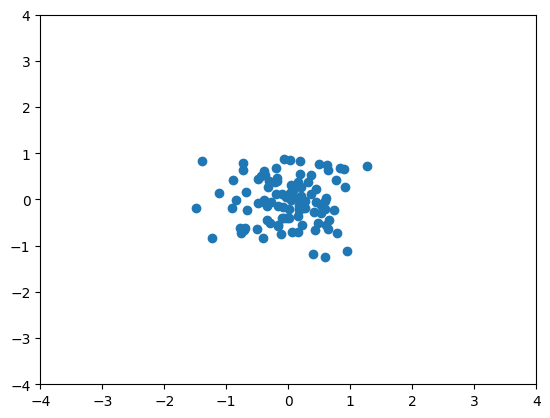

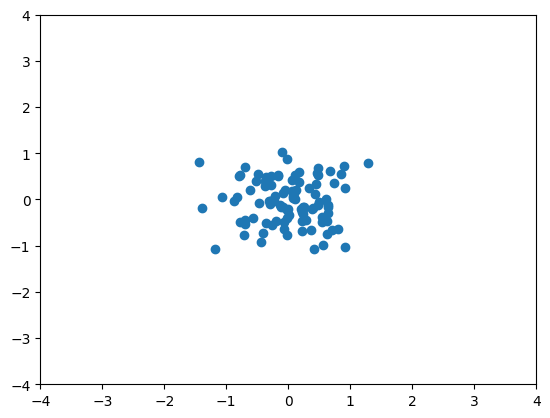

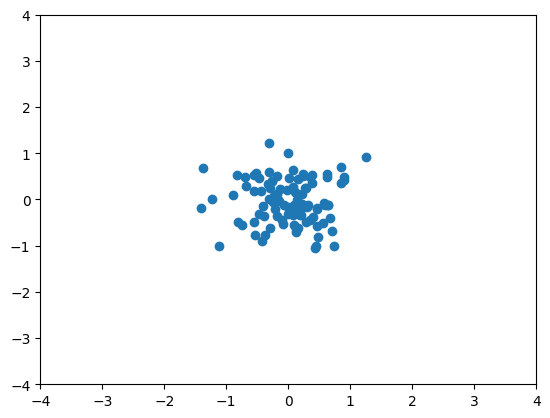

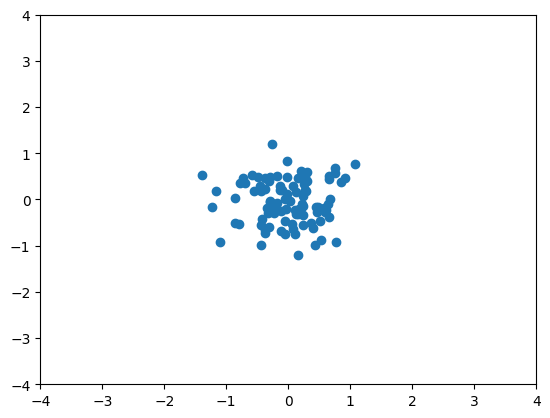

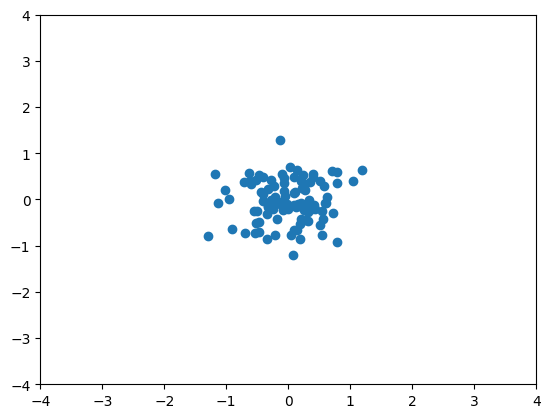

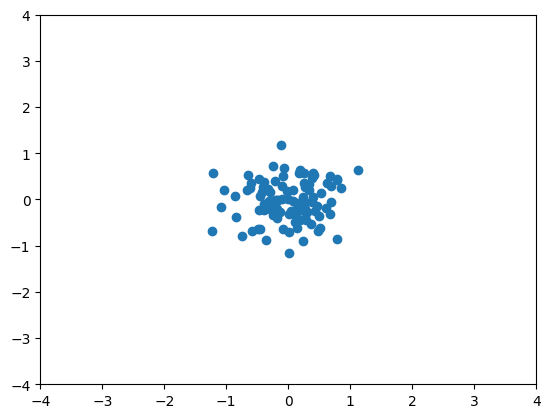

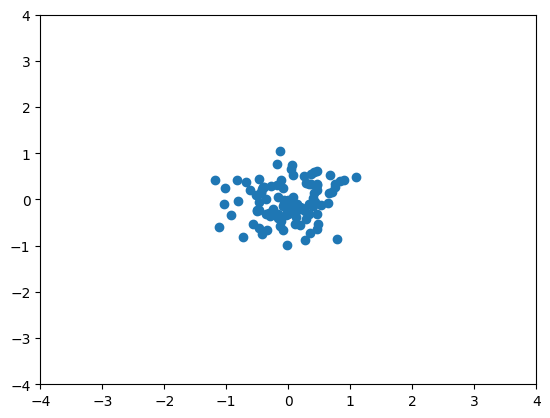

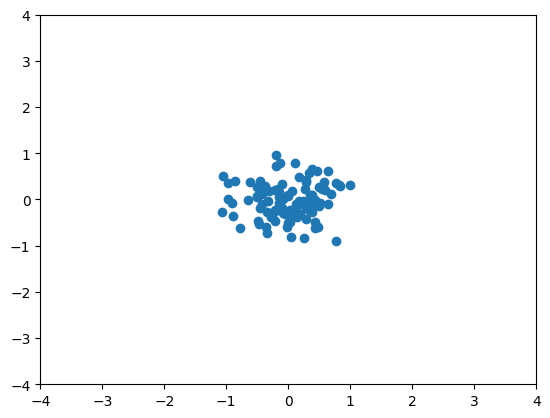

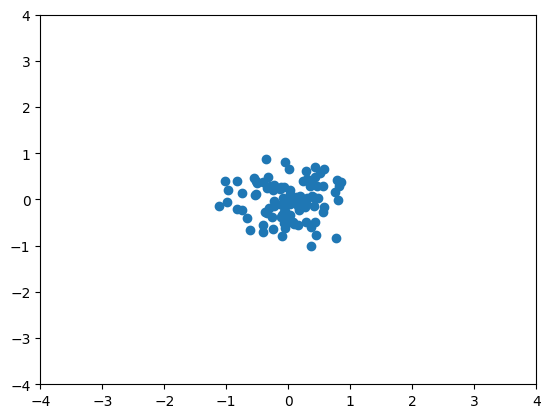

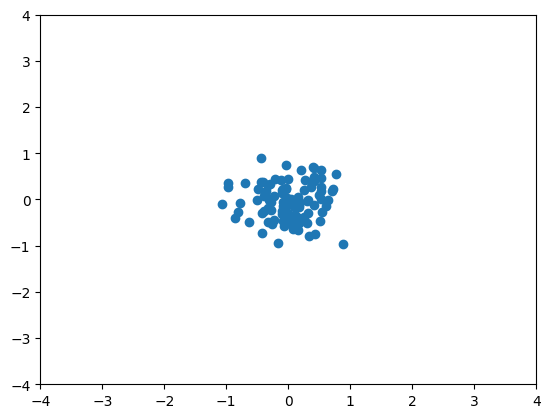

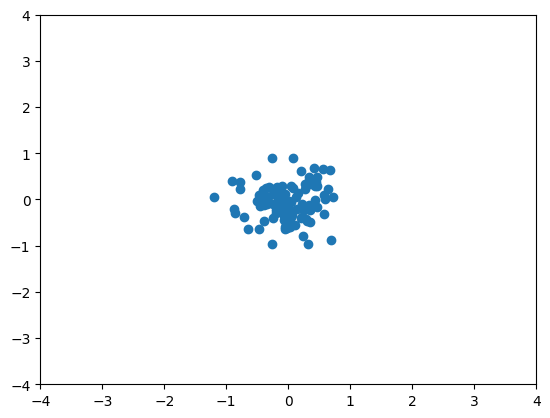

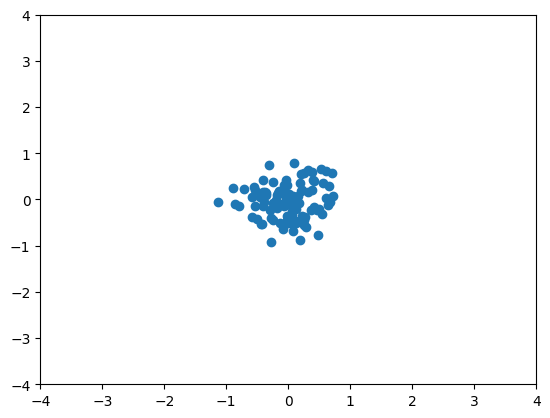

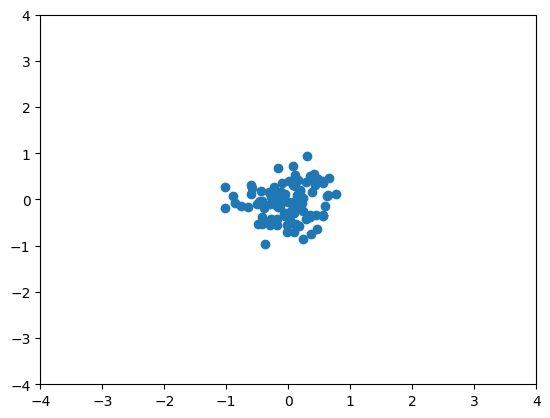

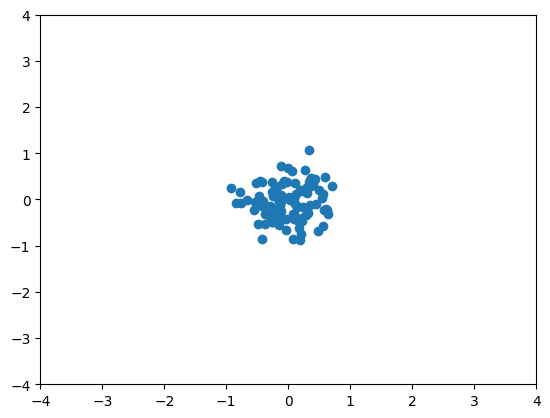

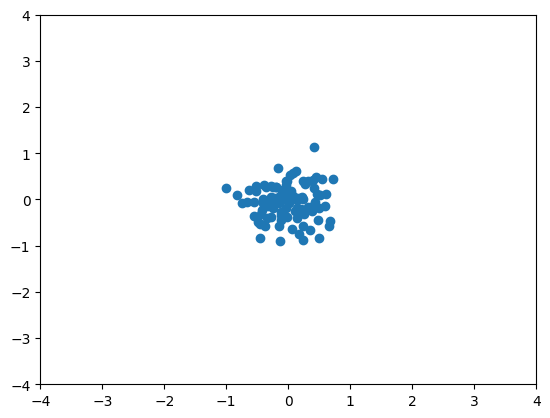

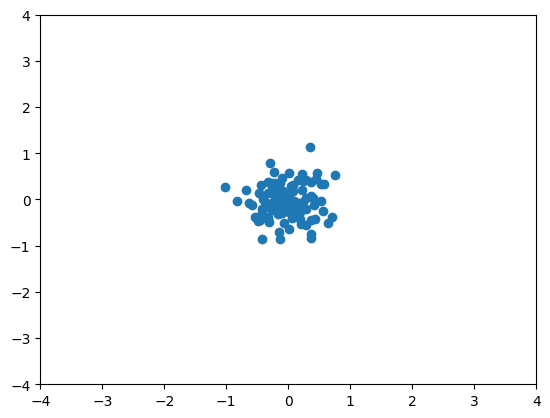

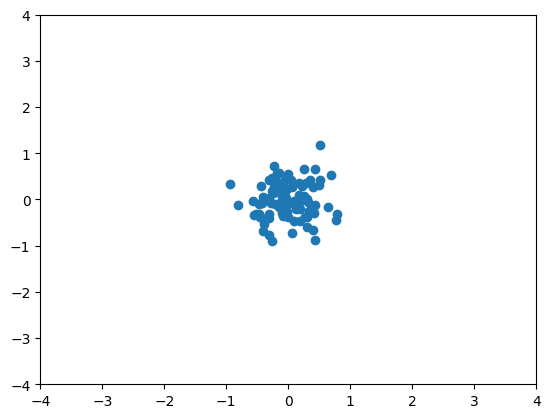

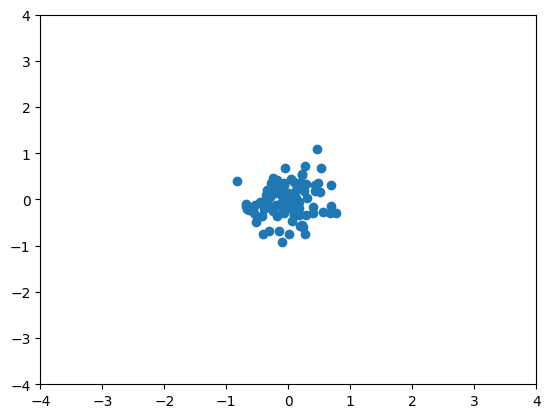

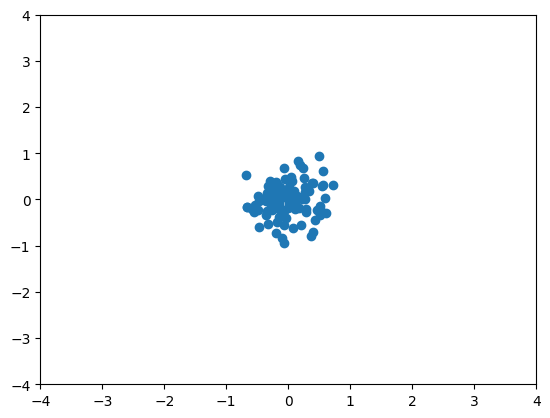

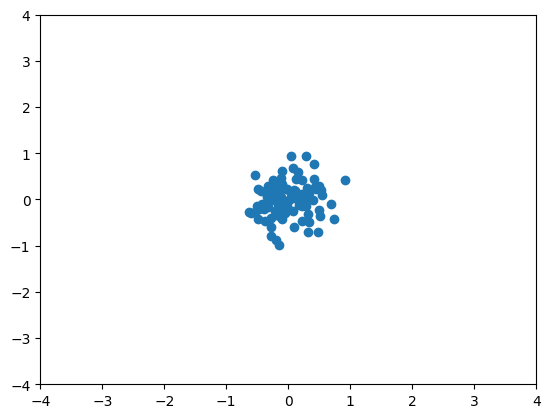

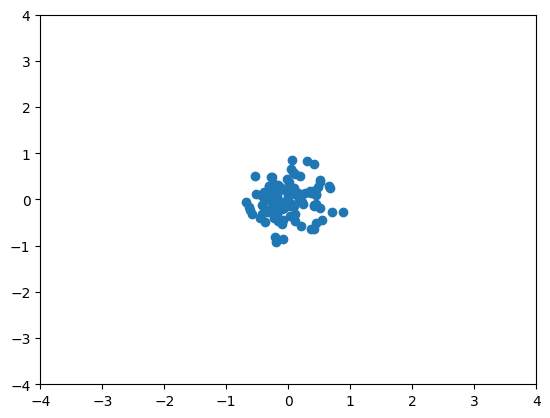

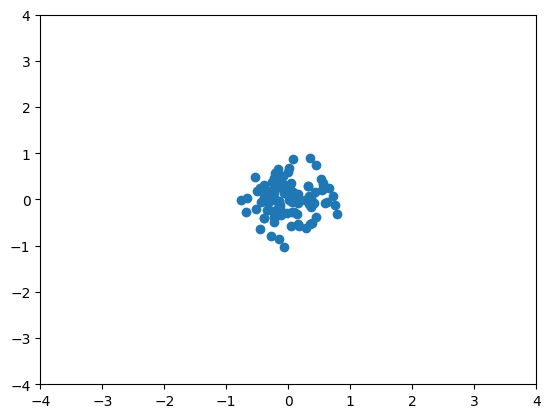

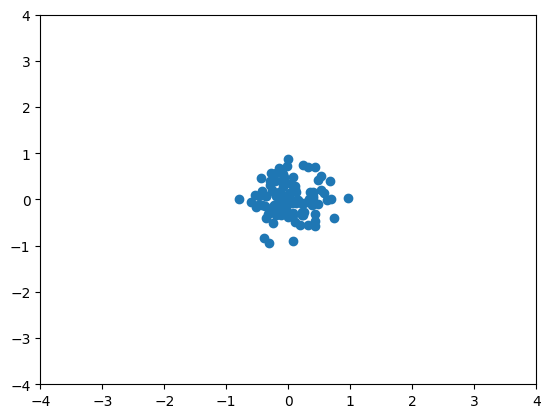

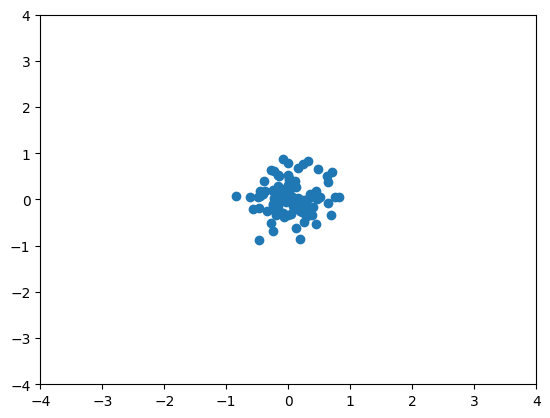

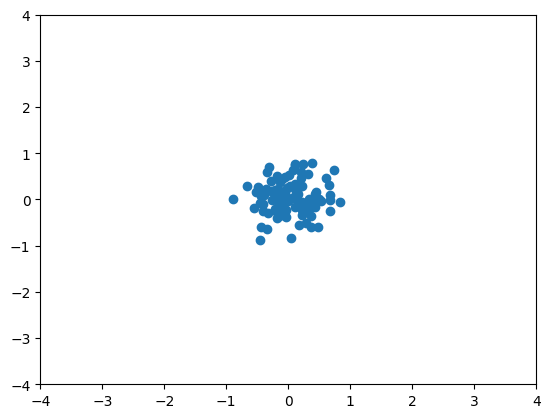

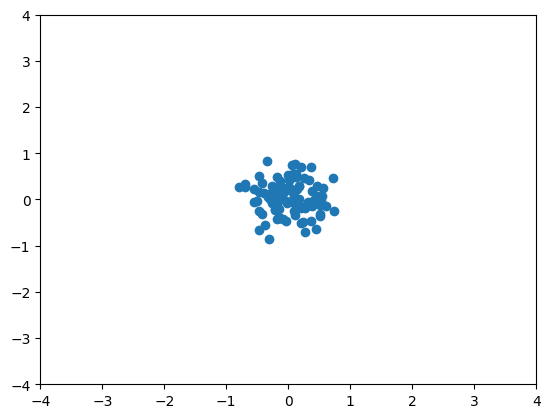

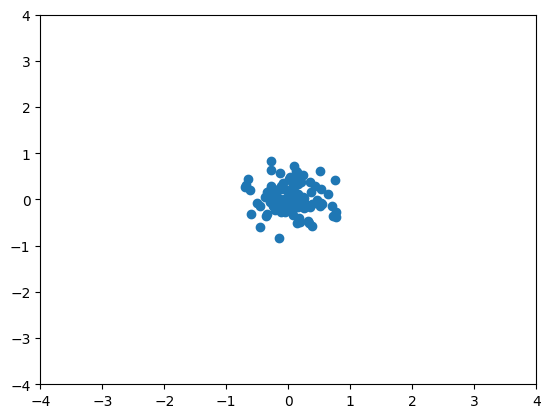

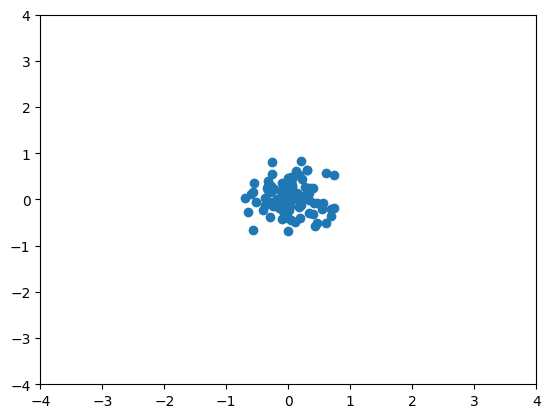

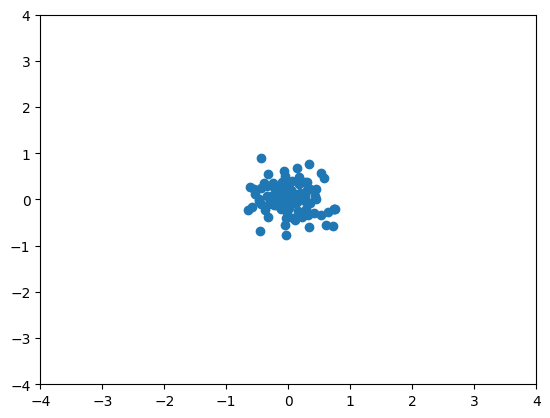

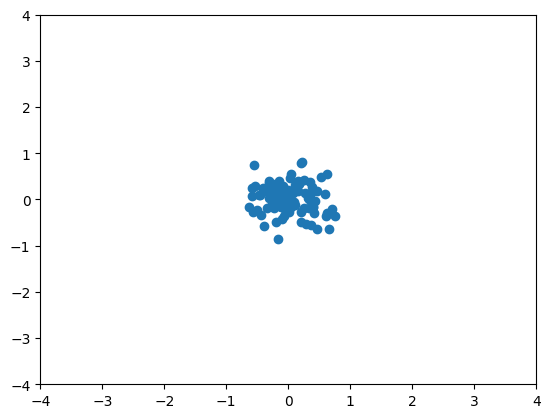

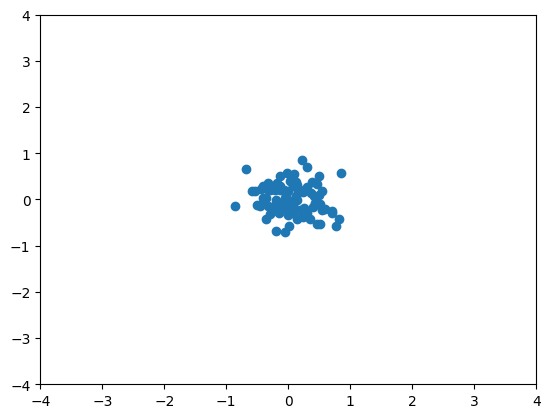

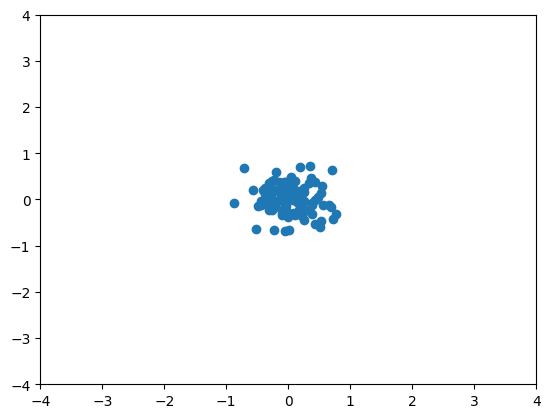

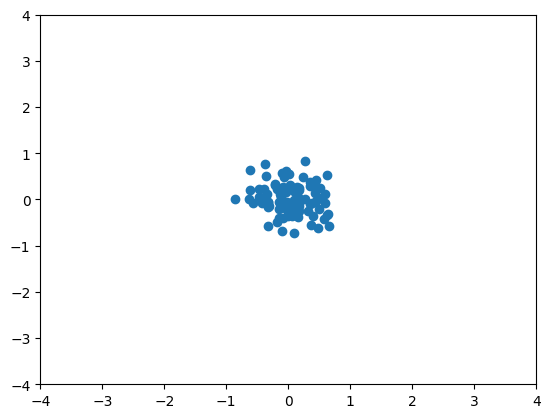

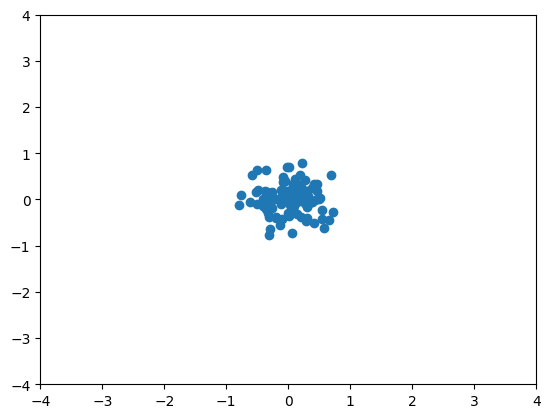

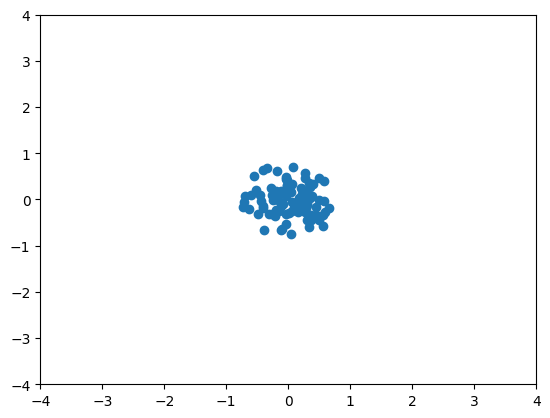

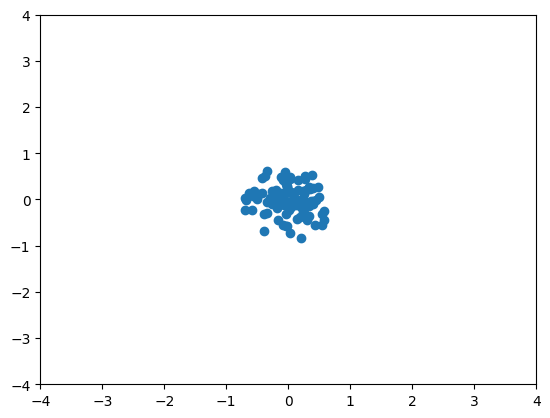

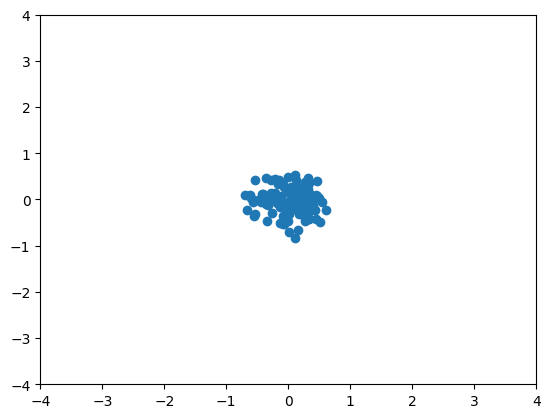

In [10]:
import matplotlib.pyplot as plt

for k in range(cfg.ebm.nb_transitions_ais):
    current_samples = samples[k].flatten(1).detach().cpu().numpy()
    plt.scatter(current_samples[:,0], current_samples[:,1])
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.show()

In [11]:
print(len(log_prob))

100
